In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
def sample_data_3():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm].astype(np.float32), data_y[perm]

(-5, 5, -5, 5)

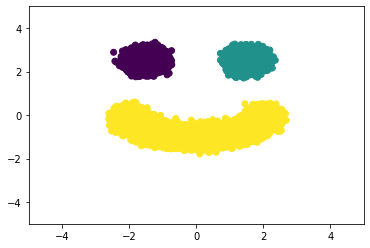

In [3]:
x, y = sample_data_3()
plt.figure()
plt.scatter(x[:,0], x[:,1], c=y)
plt.axis((-5,5,-5,5))

In [4]:
def get_warmup_temp(epoch, nrof_warmup_epochs):
    if nrof_warmup_epochs>0:
        temp = np.minimum(1.0, 1.0/nrof_warmup_epochs * epoch)
    else:
        temp = 1.0
    return temp

In [5]:
def softlimit(x, limit=0.1):
    return tf.math.log(tf.math.exp(x) + 1.0 + limit)

def dense(x, nrof_units, activation=None, training=True, use_batch_norm=False):
    x = tf.compat.v1.layers.Flatten()(x)
    x = tf.compat.v1.layers.Dense(units=nrof_units)(x)
    if use_batch_norm:
        x = tf.compat.v1.layers.BatchNormalization()(x, training=training)
    x = x if activation is None else activation(x)
    return x

def mlp(x, nrof_units, activation, nrof_layers=1, training=True):
    for _ in range(nrof_layers):
        x = dense(x, nrof_units=nrof_units, activation=activation, training=training)
    return x

def sample(mu, sigma, nrof_iw_samples=1):
    shp = tf.shape(mu)
    batch_size = shp[1]
    nrof_stochastic_units = shp[2]
    epsilon = tf.random.normal((nrof_iw_samples,batch_size,nrof_stochastic_units), mean=0.0, stddev=1.0)
    return mu + sigma*epsilon

def log_normal(x, mean, log_var, eps=1e-5):
    with tf.variable_scope('log_normal'):
        c = - 0.5 * np.log(2*np.pi)
        return c - log_var/2 - (x - mean)**2 / (2 * tf.math.exp(log_var) + eps)

In [6]:
def create_dataset(x, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(x)
    dataset = dataset.repeat()   # Repeat the dataset indefinitely
    dataset = dataset.shuffle(10000)   # Shuffle the data
    dataset = dataset.batch(batch_size)  # Create batches of data
    dataset = dataset.prefetch(batch_size)  # Prefetch data for faster consumption
    iterator = tf.compat.v1.data.make_initializable_iterator(dataset)  # Create an iterator over the dataset
    return iterator

In [7]:
def vae(x, temp, nrof_mlp_units, nrof_stochastic_units, nrof_layers, nrof_iw_samples, is_training):
    dbg = dict()
    
    batch_size = tf.shape(x)[0]
    dbg['x'] = x
    h = x
    with tf.variable_scope('encoder'):
        h = mlp(h, nrof_mlp_units, activation=tf.nn.leaky_relu, nrof_layers=nrof_layers, training=is_training)
        q_mu = dense(h, nrof_stochastic_units, training=is_training)
        q_sigma = dense(h, nrof_stochastic_units, activation=softlimit, training=is_training)

        q_mu = tf.expand_dims(q_mu, axis=0)
        q_sigma = tf.expand_dims(q_sigma, axis=0)
        dbg['q_mu'] = q_mu
        dbg['q_sigma'] = q_sigma

    with tf.variable_scope('decoder'):
        z = tf.reshape(sample(q_mu, q_sigma, nrof_iw_samples), (-1, nrof_stochastic_units))
        
        dbg['z'] = z
        h = mlp(z, nrof_mlp_units, activation=tf.nn.leaky_relu, nrof_layers=nrof_layers, training=is_training)
        x_rec_mu = tf.reshape(dense(h, nrof_stochastic_units, training=is_training), (nrof_iw_samples,batch_size,nrof_stochastic_units))
        x_rec_sigma = tf.reshape(dense(h, nrof_stochastic_units, activation=softlimit, training=is_training), (nrof_iw_samples,batch_size,nrof_stochastic_units))
        dbg['x_rec_mu'] = x_rec_mu
        dbg['x_rec_sigma'] = x_rec_sigma
        dbg['x_sample'] = sample(x_rec_mu, x_rec_sigma)

    with tf.variable_scope('rec_loss'):
        log_pxz = log_normal(x, x_rec_mu, tf.math.log(x_rec_sigma)*2)
        dbg['log_pxz'] = tf.reduce_mean(log_pxz) * np.log2(np.e)
    
    with tf.variable_scope('reg_loss'):
        p_mu, p_sigma = tf.zeros_like(q_mu), tf.ones_like(q_sigma)
        zx = tf.reshape(z, (nrof_iw_samples,batch_size,nrof_stochastic_units))
        log_qz = log_normal(zx, q_mu, tf.math.log(q_sigma)*2)
        log_pz = log_normal(zx, p_mu, tf.math.log(p_sigma)*2)
        dbg['log_pzx'] = tf.reduce_mean(log_pz - log_qz) * np.log2(np.e)
    
    with tf.variable_scope('elbo'):
        a = tf.reduce_mean(log_pxz + temp*(log_pz-log_qz), axis=2)
        a_max = tf.reduce_max(a, axis=0, keepdims=True)
        elbo = (tf.reduce_mean(a_max) + tf.reduce_mean(tf.log(tf.reduce_mean(tf.exp(a-a_max), axis=0)))) * np.log2(np.e)
        
    dbg['elbo'] = elbo
    loss = -elbo

    return loss, dbg

In [8]:
np.log2(np.e)

1.4426950408889634

In [9]:
nrof_epochs = 20
batch_size = 100
nrof_stochastic_units = 2
nrof_mlp_units = 128
nrof_layers = 3
nrof_warmup_epochs = 5
nrof_iw_samples_train = 1

x_train = x[:70000,:]
y_train = y[:70000]
x_val = x[70000:80000,:]
y_val = x[70000:80000]
x_test = x[80000:,:]
y_test = x[80000:]

tf.set_random_seed(42)
np.random.seed(42)

tf.reset_default_graph()
with tf.Graph().as_default():
    train_iterator = create_dataset(x_train, batch_size)
    eval_input_ph = tf.placeholder(tf.float32, shape=(None, 2))
    temp_ph = tf.placeholder(tf.float32, shape=())

    with tf.variable_scope('model', reuse=False):
        train_loss, train_dbg = vae(train_iterator.get_next(), temp_ph, nrof_mlp_units=nrof_mlp_units,  
            nrof_stochastic_units=nrof_stochastic_units, nrof_layers=nrof_layers, nrof_iw_samples=nrof_iw_samples_train, 
            is_training=True)
    with tf.variable_scope('model', reuse=True):
        eval1_loss, eval1_dbg = vae(eval_input_ph, temp_ph, nrof_mlp_units=nrof_mlp_units, 
            nrof_stochastic_units=nrof_stochastic_units, nrof_layers=nrof_layers, nrof_iw_samples=1, 
            is_training=False)
    with tf.variable_scope('model', reuse=True):
        eval100_loss, eval100_dbg = vae(eval_input_ph, temp_ph, nrof_mlp_units=nrof_mlp_units, 
            nrof_stochastic_units=nrof_stochastic_units, nrof_layers=nrof_layers, nrof_iw_samples=100, 
            is_training=False)

    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    train_op = optimizer.minimize(train_loss)

    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    sess.run(train_iterator.initializer)

    nrof_batches = x_train.shape[0] // batch_size

    train_elbo_list, train_log_pxz_list, train_log_pzx_list = [], [], []
    val1_elbo_list, val1_log_pxz_list, val1_log_pzx_list = [], [], []
    val100_elbo_list, val100_log_pxz_list, val100_log_pzx_list = [], [], []
    for epoch in range(1, nrof_epochs+1):
        temp = get_warmup_temp(epoch, nrof_warmup_epochs)
        for i in range(nrof_batches):
            _, loss_, dbg_ = sess.run([train_op, train_loss, train_dbg], feed_dict={temp_ph:temp})
            train_elbo_list += [ dbg_['elbo'] ]
            train_log_pxz_list += [ dbg_['log_pxz'] ]
            train_log_pzx_list += [ dbg_['log_pzx'] ]
        print('train epoch: %4d  temp: %7.3f  loss: %7.3f  p(x|z): %7.3f  p(z|x): %7.3f' % (
            epoch, temp, loss_, dbg_['log_pxz'], dbg_['log_pzx']))

        loss_, dbg_ = sess.run([eval1_loss, eval1_dbg], feed_dict={eval_input_ph:x_val, temp_ph:1.0})
        val1_elbo_list += [ dbg_['elbo'] ]
        val1_log_pxz_list += [ dbg_['log_pxz'] ]
        val1_log_pzx_list += [ dbg_['log_pzx'] ]
        print('val epoch:   %4d  loss: %7.3f  p(x|z): %7.3f  p(z|x): %7.3f' % (
            epoch, loss_, dbg_['log_pxz'], dbg_['log_pzx']))

        loss_, dbg_ = sess.run([eval100_loss, eval100_dbg], feed_dict={eval_input_ph:x_val, temp_ph:1.0})
        val100_elbo_list += [ dbg_['elbo'] ]
        val100_log_pxz_list += [ dbg_['log_pxz'] ]
        val100_log_pzx_list += [ dbg_['log_pzx'] ]
        print('val epoch:   %4d  loss: %7.3f  p(x|z): %7.3f  p(z|x): %7.3f' % (
            epoch, loss_, dbg_['log_pxz'], dbg_['log_pzx']))

    loss_, dbg_ = sess.run([eval1_loss, eval1_dbg], feed_dict={eval_input_ph:x_test[:10000,:], temp_ph:1.0})
    print('test epoch:  %4d  loss: %7.3f  p(x|z): %7.3f  p(z|x): %7.3f' % (
        epoch, loss_, dbg_['log_pxz'], dbg_['log_pzx']))
    loss_, dbg_ = sess.run([eval100_loss, eval100_dbg], feed_dict={eval_input_ph:x_test[:10000,:], temp_ph:1.0})
    print('test epoch:  %4d  loss: %7.3f  p(x|z): %7.3f  p(z|x): %7.3f' % (
        epoch, loss_, dbg_['log_pxz'], dbg_['log_pzx']))


W1006 16:35:40.752515 140048423749440 deprecation.py:506] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1006 16:35:41.439243 140048423749440 deprecation.py:323] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


train epoch:    1  temp:   0.200  loss:  -0.393  p(x|z):   1.387  p(z|x):  -4.969
val epoch:      1  loss:   3.657  p(x|z):   1.416  p(z|x):  -5.073
val epoch:      1  loss:   3.573  p(x|z):   1.424  p(z|x):  -5.089
train epoch:    2  temp:   0.400  loss:   0.310  p(x|z):   1.309  p(z|x):  -4.048
val epoch:      2  loss:   2.720  p(x|z):   1.335  p(z|x):  -4.054
val epoch:      2  loss:   2.646  p(x|z):   1.337  p(z|x):  -4.056
train epoch:    3  temp:   0.600  loss:   1.042  p(x|z):   1.043  p(z|x):  -3.475
val epoch:      3  loss:   2.459  p(x|z):   1.188  p(z|x):  -3.647
val epoch:      3  loss:   2.366  p(x|z):   1.193  p(z|x):  -3.642
train epoch:    4  temp:   0.800  loss:   1.617  p(x|z):   1.045  p(z|x):  -3.327
val epoch:      4  loss:   2.305  p(x|z):   1.111  p(z|x):  -3.416
val epoch:      4  loss:   2.221  p(x|z):   1.105  p(z|x):  -3.404
train epoch:    5  temp:   1.000  loss:   2.199  p(x|z):   1.001  p(z|x):  -3.200
val epoch:      5  loss:   2.198  p(x|z):   1.011  p(z

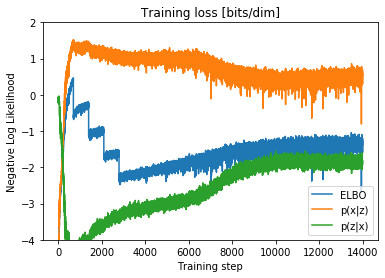

In [10]:
plt.plot(train_elbo_list)
plt.plot(train_log_pxz_list)
plt.plot(train_log_pzx_list)
plt.ylim((-4.0, 2.0))
plt.title('Training loss [bits/dim]')
plt.xlabel('Training step')
plt.legend(['ELBO', 'p(x|z)', 'p(z|x)'])
_ = plt.ylabel('Negative Log Likelihood')

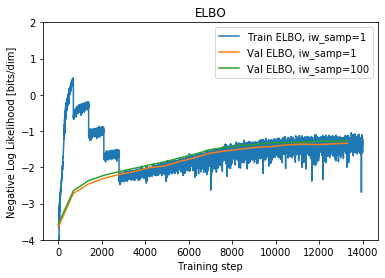

In [11]:
plt.plot(train_elbo_list)
val_x = np.arange(0,len(val1_elbo_list)*nrof_batches,nrof_batches)
plt.plot(val_x, val1_elbo_list)
plt.plot(val_x, val100_elbo_list)
plt.ylim((-4.0,2.0))
plt.title('ELBO')
plt.legend(['Train ELBO, iw_samp=1', 'Val ELBO, iw_samp=1', 'Val ELBO, iw_samp=100'])
plt.xlabel('Training step')
_ = plt.ylabel('Negative Log Likelihood [bits/dim]')

(-5, 5, -5, 5)

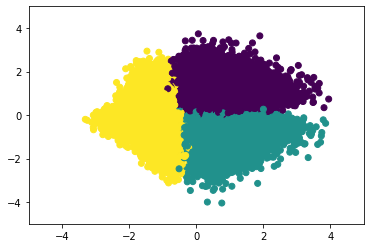

In [12]:
dbg_ = sess.run(eval1_dbg, feed_dict={eval_input_ph:x_train, temp_ph:1.0})
plt.figure()
plt.scatter(dbg_['z'][:,0], dbg_['z'][:,1], c=y_train)
plt.axis((-5,5,-5,5))